# <div align="center"> COSC 2673/2793 | Machine Learning </div>

## <div align="center"> Assignment 2 - Joseph Packham (s3838978) and Kylie Nguyen (s3946026) </div>


# Introduction

This report will cover the process of producing a machine learning model that will predict energy usage...


In [215]:
# importing packages
# import seaborn package for plotting scatterplots
import seaborn as sns

import pandas as pd



import matplotlib.pyplot as plt


import numpy as np


from sklearn.model_selection import train_test_split


import tensorflow as tf


import pydot as pyd


from tensorflow.keras.metrics import MeanAbsoluteError


from sklearn.preprocessing import StandardScaler


from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras import regularizers


from tensorflow.keras.layers import Dropout, BatchNormalization


from sklearn.preprocessing import PowerTransformer


from tensorflow.keras.optimizers import Adam


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.utils import compute_sample_weight
from tensorflow.keras.losses import Huber

In [ ]:
# read in CSV file and display first 5 rows
energyUse_df = pd.read_csv("./dataset/UCI-electricity/UCI_data.csv", delimiter=",")
energyUse_df.head()

# Exploratory Data Analysis

First, the data is investigated through EDA. It is observed that the shape of the dataframe is 19735 rows of data with 28 columns, where 1 column is the target variable (energy usage in Wh), and the remaining columns are the attributes. According to the description of the data, these attributes cover the temperature and humidity of different rooms in the house, as well as outside, along with a few other weather related variables such as pressure and windspeed. It is noted that there are two variables listed as "Random Variable". Using the .info() function, it is confirmed that there are no null values within the dataset.


In [ ]:
# check for any null values, using shape to compare
print("Shape of Energy Use dataframe: ", energyUse_df.shape, "\n")

energyUse_df.info()

Using the describe function, the count, mean, standard deviation, quantiles and the minimum and maximum values of the data are returned. With these values it is seen that, although the range of the values among the variables regarding humidity and temperature are relatively similar, there are cases where the range differs greatly. For example, the range of Windspeed is between 0-14, whereas the range of target energy is between 10-1110. This suggests that feature scaling should be done later in the process, as the differing ranges may cause problems or confuse the learning algorithms.


In [ ]:
energyUse_df.describe()

# Data distribution

In order to observe the distributions of each variable, histograms are plotted for the variables other than date, as the date variable is of type object and cannot be plotted.


In [ ]:
# get list of columns other than date
columns = (energyUse_df.columns).difference(["date"])
# plot histogram for all variables other than date
plt.figure(figsize=(20, 20))
for i, column in enumerate(columns):
    plt.subplot(6, 5, i + 1)
    plt.hist(energyUse_df[column], alpha=0.3, color="b", density=True)
    plt.title(column)
    plt.xticks(rotation="vertical")
    plt.tight_layout()

> **Observations:**
>
> - There are a number of attributes that appear to be skewed, eg. RH_5, RH_Out, T2 etc.
> - The two random variables are very evenly distributed.


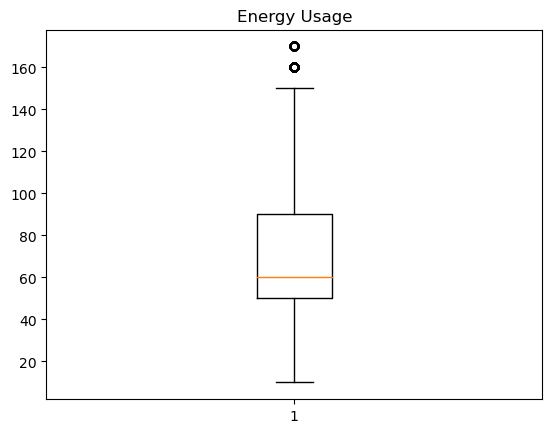

In [70]:
# display boxplot for the target, energy usage, variable
plt.boxplot(energyUse_df["TARGET_energy"])
plt.title("Energy Usage")
plt.show()

After displaying the boxplot for the target variable, it is observed that there are a number of outliers above the lower limit. These values will be dropped as to prevent these dramatically different values from affecting the model. The outliers are dropped using the IQR method.


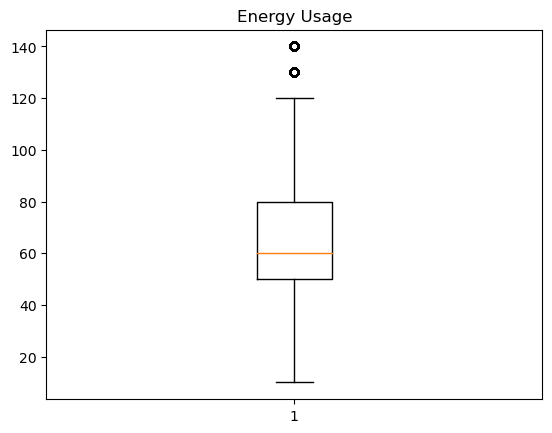

In [71]:
# get the quantiles and IQR
q1 = energyUse_df["TARGET_energy"].quantile(0.25)
q3 = energyUse_df["TARGET_energy"].quantile(0.75)
IQR = q3 - q1

# calculate lower and upper limits
lowerLimit = q1 - (1.5 * IQR)
upperLimit = q3 + (1.5 * IQR)

# get rid of rows with outliers from the dataframe
energyUse_df = energyUse_df.loc[
    (energyUse_df["TARGET_energy"] > lowerLimit)
    & (energyUse_df["TARGET_energy"] < upperLimit)
]

# display boxplot without outliers
plt.boxplot(energyUse_df["TARGET_energy"])
plt.title("Energy Usage")
plt.show()

In [ ]:
energyUse_df.shape

# Relationship between variables

Using scatterplots, the relationship between the target variable, Energy Usage, against the other attributes in the dataframe is explored.


In [ ]:


# plot scatterplots for all features against target variable
plt.figure(figsize=(20, 20))
for i, column in enumerate(columns):
    plt.subplot(6, 5, i + 1)
    sns.scatterplot(data=energyUse_df, x=column, y="TARGET_energy")
    plt.title(column)

plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

In [ ]:
# get list of columns other than date and target
columns = (energyUse_df.columns).difference(["date", "TARGET_energy"])

g = sns.PairGrid(data=energyUse_df, vars=columns, hue="TARGET_energy")
g.map(sns.scatterplot)
plt.show()

> **Observations:**
>
> - There are some plots that show that a linear decision boundary may be able to separate the two classes. eg.
> - Whereas there are some plots that show that a non-linear decision boundary may be to separate the two classes.


[Text(0.5, 0, 'T1'),
 Text(1.5, 0, 'RH_1'),
 Text(2.5, 0, 'T2'),
 Text(3.5, 0, 'RH_2'),
 Text(4.5, 0, 'T3'),
 Text(5.5, 0, 'RH_3'),
 Text(6.5, 0, 'T4'),
 Text(7.5, 0, 'RH_4'),
 Text(8.5, 0, 'T5'),
 Text(9.5, 0, 'RH_5'),
 Text(10.5, 0, 'T6'),
 Text(11.5, 0, 'RH_6'),
 Text(12.5, 0, 'T7'),
 Text(13.5, 0, 'RH_7'),
 Text(14.5, 0, 'T8'),
 Text(15.5, 0, 'RH_8'),
 Text(16.5, 0, 'T9'),
 Text(17.5, 0, 'RH_9'),
 Text(18.5, 0, 'T_out'),
 Text(19.5, 0, 'Press_mm_hg'),
 Text(20.5, 0, 'RH_out'),
 Text(21.5, 0, 'Windspeed'),
 Text(22.5, 0, 'Visibility'),
 Text(23.5, 0, 'Tdewpoint'),
 Text(24.5, 0, 'rv1'),
 Text(25.5, 0, 'rv2'),
 Text(26.5, 0, 'TARGET_energy'),
 Text(27.5, 0, 'hour'),
 Text(28.5, 0, 'day'),
 Text(29.5, 0, 'month'),
 Text(30.5, 0, 'year')]

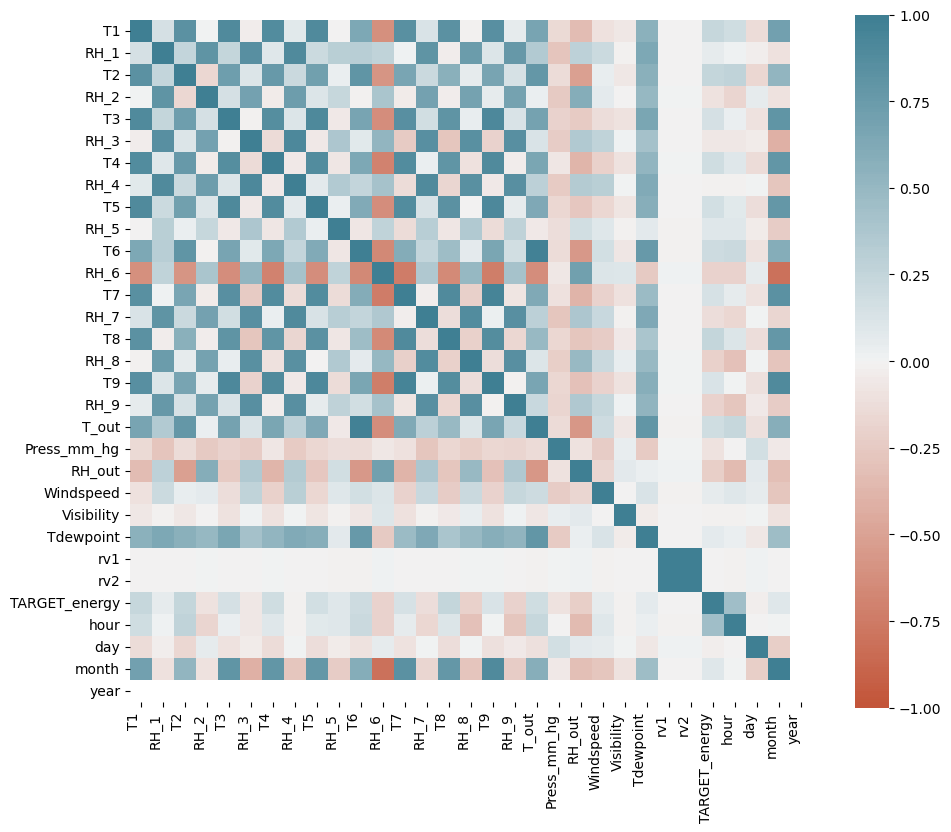

In [56]:
# get df without date column
energyUse_df_noDate = energyUse_df.drop(columns=["date"])

# plot correlation plot
f, ax = plt.subplots(figsize=(11, 9))
corr = energyUse_df_noDate.corr()
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")

> **Observations:**
>
> - Variables relating to temperature are highly positively correlated with each other, and variables that are related to humidity are similarly, highly positively correlated with each other.
> - Variables involving temperature generally have either a slight positive, or slight negative correlation with variables involving humidity.
> - RH_6, the humidity outside the building (northside) seems to be quite negatively correlated with variables regarding temperature.
> - The two random variables do not seem to be correlated with any other variable other being highly correlated with themselves as well as each other.


In [ ]:
energyUse_df["TARGET_energy"].hist(figsize=(5, 5))
plt.xlabel("Energy Usage")
plt.ylabel("frequency")
plt.show()

# Creating Neural Network


In [ ]:
# function to plot learning curve
def plot_learning_curve(
    train_loss, val_loss, train_metric, val_metric, metric_name="MeanAbsoluteError"
):

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, "r--")
    plt.plot(val_loss, "b--")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_metric, "r--")
    plt.plot(val_metric, "b--")
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(["train", "val"], loc="upper left")


    plt.show()
# function for residual plot
def plot_residuals(model, val_y, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)

    xlims = ax.get_xlim()
    ax.plot(xlims, [0, 0], "k-", alpha=0.75, zorder=0)
    ax.set_xlim(xlims)

    plt.xlabel("energy usage")
    plt.ylabel("Residuals")
    plt.title(model)
    plt.show()

In [ ]:
# split the data into traing, testing and validation

with pd.option_context("mode.chained_assignment", None):
    train_data, test_data = train_test_split(
        energyUse_df, test_size=0.3, shuffle=True, random_state=42
    )
    test_data, val_data = train_test_split(
        test_data, test_size=0.5, shuffle=True, random_state=42
    )

# remove the target column from the data
X_train = train_data.drop(columns=["TARGET_energy", "date"])
y_train = train_data["TARGET_energy"]

X_test = test_data.drop(columns=["TARGET_energy", "date"])
y_test = test_data["TARGET_energy"]

X_val = val_data.drop(columns=["TARGET_energy", "date"])
y_val = val_data["TARGET_energy"]

# train data - used to train the model
# validation data - used to tune the hyperparameters
# test data - used to evaluate the final model

# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

## Base Neural Network on unchanged Data


In [ ]:
# base model values
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation="linear"),
    ]
)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1
)

In [ ]:
plot_learning_curve(
    history.history["loss"],
    history.history["val_loss"],
    history.history["mean_absolute_error"],
    history.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val)
print("Validation loss: ", val_loss)
print("Validation MAE: ", val_mae)

#### Observations

- the model performs extremely poorly
- neds significant improvement
  -over fitting is a major issue


In [ ]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [ ]:

model2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ]
)

model2.summary()
tf.keras.utils.plot_model(model2, show_shapes=True)


# compile model
model2.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history2 = model2.fit(
    X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, verbose=1
)

In [ ]:
# plot graph
plot_learning_curve(
    history2.history["loss"],
    history2.history["val_loss"],
    history2.history["mean_absolute_error"],
    history2.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model2.evaluate(X_val_scaled, y_val)
print("Validation loss: ", val_loss)
print("Validation MAE: ", val_mae)

- still seems to be overfitting possibly


In [ ]:
# change batchsize

INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 64

# create model
model3 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ]
)

# compile model
model3.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history3 = model3.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

In [ ]:
# plot learning curve
plot_learning_curve(
    history3.history["loss"],
    history3.history["val_loss"],
    history3.history["mean_absolute_error"],
    history3.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model3.evaluate(X_val_scaled, y_val)

In [ ]:
# change batch size
BATCH_SIZE = 256

# fit model
history4 = model3.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

In [ ]:
# plot learning curve
plot_learning_curve(
    history4.history["loss"],
    history4.history["val_loss"],
    history4.history["mean_absolute_error"],
    history4.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model3.evaluate(X_val_scaled, y_val)

Model is overfitting


In [ ]:
# try regularisation
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 128

# create model
model4 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l1(0.01),
        ),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model4.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history5 = model4.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

In [ ]:
# plot learning curve
plot_learning_curve(
    history5.history["loss"],
    history5.history["val_loss"],
    history5.history["mean_absolute_error"],
    history5.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model4.evaluate(X_val_scaled, y_val)

- still overfitting the model   
-standard scaler is working better than minmax scaler

In [ ]:
# tune regularisation
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 128
REGULARIZATIONFACTOR = 5

# create model
model5 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model5.compile(
    optimizer="adam",
    loss='mean_squared_error',
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history6 = model5.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

In [ ]:
# plot learning curve
plot_learning_curve(
    history6.history["loss"],
    history6.history["val_loss"],
    history6.history["mean_absolute_error"],
    history6.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model5.evaluate(X_val_scaled, y_val)

- not greatv still but no more overfitting 

In [ ]:
# tune regularisation
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 64
REGULARIZATIONFACTOR = 0.01

# create model
model6 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(0.5),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model6.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history7 = model6.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

In [ ]:
# plot learning curve
plot_learning_curve(
    history7.history["loss"],
    history7.history["val_loss"],
    history7.history["mean_absolute_error"],
    history7.history["val_mean_absolute_error"],
)

- performing not well but better thasn the start
- will try creatting features to represent the time series data

In [72]:
# create time based features
energyUse_df["date"] = pd.to_datetime(energyUse_df["date"], format="%Y-%m-%d %H:%M:%S")
# create time-based features
energyUse_df['hour'] = energyUse_df['date'].dt.hour
energyUse_df['day'] = energyUse_df['date'].dt.day
energyUse_df['month'] = energyUse_df['date'].dt.month
energyUse_df['year'] = energyUse_df['date'].dt.year

# drop rows with missing values
energyUse_df = energyUse_df.dropna()

# resplit the data
train_data, test_data = train_test_split(energyUse_df, test_size=0.3, shuffle=True, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=42)

# remove the target column from the data
X_train = train_data.drop(columns=["TARGET_energy", "date"])
y_train = train_data["TARGET_energy"]

X_test = test_data.drop(columns=["TARGET_energy", "date"])
y_test = test_data["TARGET_energy"]

X_val = val_data.drop(columns=["TARGET_energy", "date"])
y_val = val_data["TARGET_energy"]

# train data - used to train the model
# validation data - used to tune the hyperparameters
# test data - used to evaluate the final model

# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (11921, 31)
y_train shape:  (11921,)
X_val shape:  (2555, 31)
y_val shape:  (2555,)
X_test shape:  (2555, 31)
y_test shape:  (2555,)


In [ ]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 64
REGULARIZATIONFACTOR = 0.01

# create model
model7 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(0.5),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model7.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history8 = model7.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

In [ ]:
#power transform data
scaler = PowerTransformer(method='yeo-johnson').fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)



In [ ]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 128
REGULARIZATIONFACTOR = 0.05

# create model
model8 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(0.5),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(0.5),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model8.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history9 = model8.fit(
    X_train_transformed,
    y_train,
    validation_data=(X_val_transformed, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

In [ ]:
#plot learning curve
plot_learning_curve(
    history9.history["loss"],
    history9.history["val_loss"],
    history9.history["mean_absolute_error"],
    history9.history["val_mean_absolute_error"],
)

In [ ]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM =    512
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
REGULARIZATIONFACTOR = 0.015
DROPOUT = 0.5
learningrate = 0.001
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=10)

# create model
model9 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),

        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model9.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history10 = model9.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

moidel is overfitting - parameter tuning required

In [ ]:
#Further tuning of model parameters
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model10 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model10.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history11 = model10.fit(
    X_train_transformed,
    y_train,
    validation_data=(X_val_transformed, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

In [ ]:
# r2 score
# Generate predictions
y_val_pred = model10.predict(X_val_transformed)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

#residual plot
plot_residuals("Model 10", y_val, y_val_pred)

In [60]:
# drop rh6
X_train= X_train.drop(columns=["RH_6"])
X_val = X_val.drop(columns=["RH_6"])
X_test = X_test.drop(columns=["RH_6"])
# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
#standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)


KeyError: "['RH_6'] not found in axis"

In [61]:

INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model11 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model11.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history12 = model11.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
24/24 - 2s - loss: 5744.1729 - mean_absolute_error: 69.7783 - root_mean_squared_error: 75.2362 - val_loss: 7545.6636 - val_mean_absolute_error: 79.6947 - val_root_mean_squared_error: 86.3865 - lr: 0.0015 - 2s/epoch - 75ms/step
Epoch 2/100
24/24 - 0s - loss: 5311.0894 - mean_absolute_error: 67.6065 - root_mean_squared_error: 72.3101 - val_loss: 5880.0762 - val_mean_absolute_error: 70.9106 - val_root_mean_squared_error: 76.1481 - lr: 0.0015 - 417ms/epoch - 17ms/step
Epoch 3/100
24/24 - 0s - loss: 4738.2563 - mean_absolute_error: 63.4633 - root_mean_squared_error: 68.2433 - val_loss: 4636.6919 - val_mean_absolute_error: 63.1860 - val_root_mean_squared_error: 67.4971 - lr: 0.0015 - 405ms/epoch - 17ms/step
Epoch 4/100
24/24 - 0s - loss: 3865.4915 - mean_absolute_error: 56.3683 - root_mean_squared_error: 61.5199 - val_loss: 3344.6938 - val_mean_absolute_error: 52.3709 - val_root_mean_squared_error: 57.1304 - lr: 0.0015 - 407ms/epoch - 17ms/step
Epoch 5/100
24/24 - 0s - loss: 2835

83/83 [==============================] - 0s 1ms/step
R2 score: 0.6603764630957547


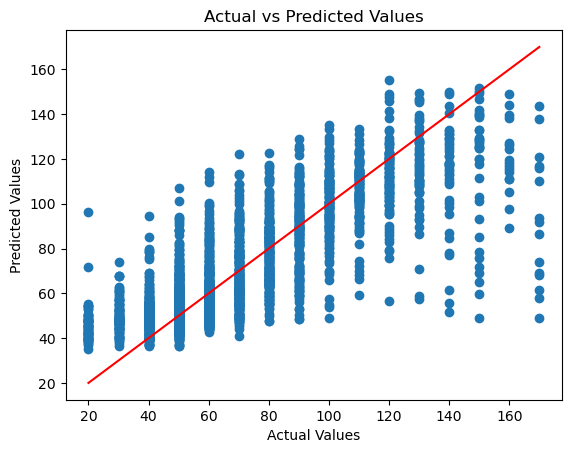

C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3819335297.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)


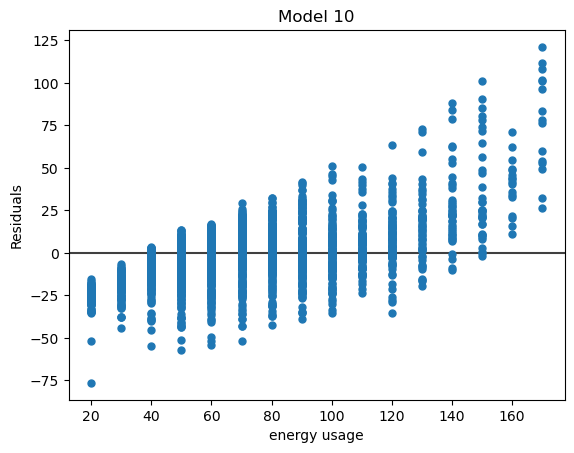

In [62]:
# r2 score
# Generate predictions
y_val_pred = model11.predict(X_val_transformed)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

#residual plot
plot_residuals("Model 11", y_val, y_val_pred)

In [63]:
# drop t6
X_train = X_train.drop(columns=["T6"])
X_val = X_val.drop(columns=["T6"])
X_test = X_test.drop(columns=["T6"])
# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
# standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)

In [64]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model12 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model12.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history13 = model12.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
24/24 - 2s - loss: 5745.2881 - mean_absolute_error: 69.7607 - root_mean_squared_error: 75.2397 - val_loss: 8770.2080 - val_mean_absolute_error: 86.1753 - val_root_mean_squared_error: 93.2022 - lr: 0.0015 - 2s/epoch - 80ms/step
Epoch 2/100
24/24 - 1s - loss: 5307.5908 - mean_absolute_error: 67.5535 - root_mean_squared_error: 72.2823 - val_loss: 5970.7700 - val_mean_absolute_error: 71.9753 - val_root_mean_squared_error: 76.7376 - lr: 0.0015 - 513ms/epoch - 21ms/step
Epoch 3/100
24/24 - 1s - loss: 4726.8066 - mean_absolute_error: 63.3704 - root_mean_squared_error: 68.1547 - val_loss: 4593.9775 - val_mean_absolute_error: 62.9271 - val_root_mean_squared_error: 67.1751 - lr: 0.0015 - 824ms/epoch - 34ms/step
Epoch 4/100
24/24 - 2s - loss: 3855.7087 - mean_absolute_error: 56.2241 - root_mean_squared_error: 61.4353 - val_loss: 3316.7861 - val_mean_absolute_error: 52.1836 - val_root_mean_squared_error: 56.8802 - lr: 0.0015 - 2s/epoch - 87ms/step
Epoch 5/100
24/24 - 2s - loss: 2830.50

In [89]:
# r2 score

# Generate predictions
y_val_pred = model12.predict(X_val_transformedandscaled)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)


print(f"R2 score: {r2}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE: {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_val, y_val_pred)
print(f"MAE: {mae}")

# Calculate MSE (loss)
mse = mean_squared_error(y_val, y_val_pred)
print(f"MSE: {mse}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model 12", y_val, y_val_pred)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_34/dense_132/Relu' defined at (most recent call last):
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3705395375.py", line 4, in <module>
      y_val_pred = model12.predict(X_val_transformed)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\Joseph\.conda\envs\Tensorflow\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_34/dense_132/Relu'
Matrix size-incompatible: In[0]: [32,29], In[1]: [26,512]
	 [[{{node sequential_34/dense_132/Relu}}]] [Op:__inference_predict_function_867453]

In [92]:
# add column for number of seconbnds from midnight
energyUse_df["seconds_from_midnight"] = (
    energyUse_df["date"].dt.hour * 3600
    + energyUse_df["date"].dt.minute * 60
    + energyUse_df["date"].dt.second
)
#add column for day of the week
energyUse_df["day_of_week"] = energyUse_df["date"].dt.dayofweek

# split the data
train_data, test_data = train_test_split(energyUse_df, test_size=0.3, shuffle=True, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=42)

# remove the target column from the data
X_train = train_data.drop(columns=["TARGET_energy", "date"])
y_train = train_data["TARGET_energy"]

X_test = test_data.drop(columns=["TARGET_energy", "date"])
y_test = test_data["TARGET_energy"]

X_val = val_data.drop(columns=["TARGET_energy", "date"])
y_val = val_data["TARGET_energy"]

# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
# standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)

# train data - used to train the model
# validation data - used to tune the hyperparameters
# test data - used to evaluate the final model

# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (11921, 32)
y_train shape:  (11921,)
X_val shape:  (2555, 32)
y_val shape:  (2555,)
X_test shape:  (2555, 32)
y_test shape:  (2555,)


Epoch 1/100
24/24 - 2s - loss: 5162.7666 - mean_absolute_error: 66.8917 - root_mean_squared_error: 71.2681 - val_loss: 9072.0449 - val_mean_absolute_error: 86.9656 - val_root_mean_squared_error: 94.8125 - lr: 0.0015 - 2s/epoch - 83ms/step
Epoch 2/100
24/24 - 0s - loss: 4790.1382 - mean_absolute_error: 64.7738 - root_mean_squared_error: 68.6174 - val_loss: 5145.4766 - val_mean_absolute_error: 67.5329 - val_root_mean_squared_error: 71.1657 - lr: 0.0015 - 424ms/epoch - 18ms/step
Epoch 3/100
24/24 - 0s - loss: 4225.6572 - mean_absolute_error: 60.5540 - root_mean_squared_error: 64.3828 - val_loss: 4095.5264 - val_mean_absolute_error: 59.9373 - val_root_mean_squared_error: 63.3667 - lr: 0.0015 - 465ms/epoch - 19ms/step
Epoch 4/100
24/24 - 0s - loss: 3398.6890 - mean_absolute_error: 53.3949 - root_mean_squared_error: 57.6069 - val_loss: 2912.9761 - val_mean_absolute_error: 49.2699 - val_root_mean_squared_error: 53.2248 - lr: 0.0015 - 378ms/epoch - 16ms/step
Epoch 5/100
24/24 - 0s - loss: 2437

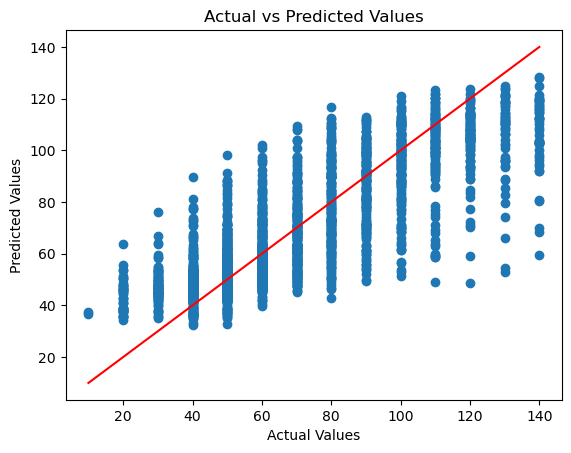

C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3819335297.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)


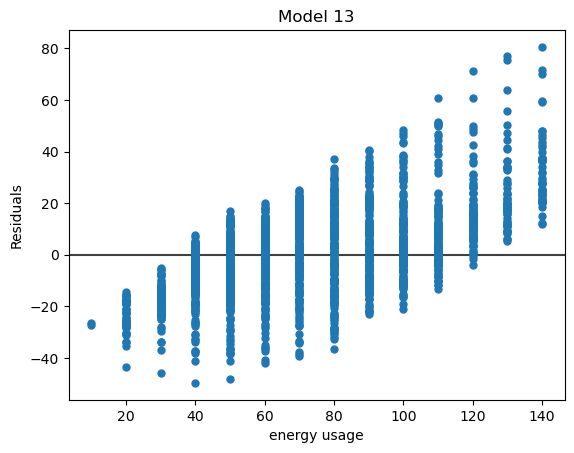

In [74]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model13 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model13.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history14 = model13.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

    # r2 score
# Generate predictions
y_val_pred = model13.predict(X_val_transformed)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model 13", y_val, y_val_pred)

In [126]:
# drop hour, day, month, year,
X_train = X_train.drop(columns=["hour", "day", "month", "year"])
X_val = X_val.drop(columns=["hour", "day", "month", "year"])
X_test = X_test.drop(columns=["hour", "day", "month", "year"])
# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
# standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)


KeyError: "['hour', 'day', 'month', 'year'] not found in axis"

Epoch 1/100
24/24 - 3s - loss: 5168.9175 - mean_absolute_error: 66.8902 - root_mean_squared_error: 71.3126 - val_loss: 7910.9980 - val_mean_absolute_error: 83.2251 - val_root_mean_squared_error: 88.4789 - lr: 0.0015 - 3s/epoch - 117ms/step
Epoch 2/100
24/24 - 1s - loss: 4788.9575 - mean_absolute_error: 64.7462 - root_mean_squared_error: 68.6084 - val_loss: 5430.6021 - val_mean_absolute_error: 69.1175 - val_root_mean_squared_error: 73.1400 - lr: 0.0015 - 516ms/epoch - 21ms/step
Epoch 3/100
24/24 - 0s - loss: 4228.7969 - mean_absolute_error: 60.5168 - root_mean_squared_error: 64.4046 - val_loss: 4295.5029 - val_mean_absolute_error: 61.3545 - val_root_mean_squared_error: 64.9223 - lr: 0.0015 - 494ms/epoch - 21ms/step
Epoch 4/100
24/24 - 1s - loss: 3399.7866 - mean_absolute_error: 53.3691 - root_mean_squared_error: 57.6129 - val_loss: 3177.6257 - val_mean_absolute_error: 51.7990 - val_root_mean_squared_error: 55.6516 - lr: 0.0015 - 514ms/epoch - 21ms/step
Epoch 5/100
24/24 - 1s - loss: 243

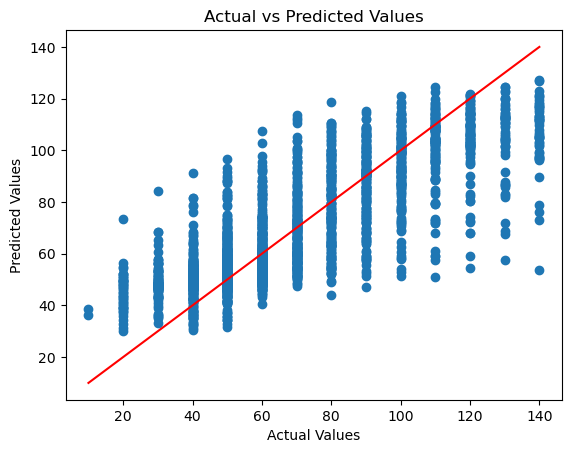

C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3819335297.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)


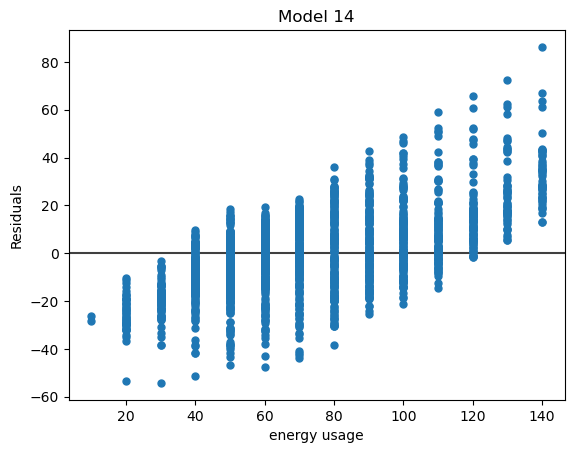

In [127]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model14 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model14.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history15 = model14.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

# r2 score
# Generate predictions
y_val_pred = model14.predict(X_val_transformed)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model 14", y_val, y_val_pred)

In [125]:
# add colkumn to check if day is weekday or weekend
X_train["is_weekend"] = X_train["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
X_val["is_weekend"] = X_val["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
X_test["is_weekend"] = X_test["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
# standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)

#shape of the data
print("X_train shape: ", X_train.shape)

X_train shape:  (11921, 29)


Epoch 1/100
24/24 - 2s - loss: 5169.2163 - mean_absolute_error: 66.8772 - root_mean_squared_error: 71.3147 - val_loss: 6481.3047 - val_mean_absolute_error: 73.7883 - val_root_mean_squared_error: 79.9924 - lr: 0.0015 - 2s/epoch - 78ms/step
Epoch 2/100
24/24 - 0s - loss: 4776.9634 - mean_absolute_error: 64.7095 - root_mean_squared_error: 68.5206 - val_loss: 4843.5293 - val_mean_absolute_error: 64.4764 - val_root_mean_squared_error: 69.0097 - lr: 0.0015 - 426ms/epoch - 18ms/step
Epoch 3/100
24/24 - 1s - loss: 4223.4214 - mean_absolute_error: 60.4374 - root_mean_squared_error: 64.3624 - val_loss: 4045.5232 - val_mean_absolute_error: 59.1791 - val_root_mean_squared_error: 62.9671 - lr: 0.0015 - 605ms/epoch - 25ms/step
Epoch 4/100
24/24 - 1s - loss: 3388.0039 - mean_absolute_error: 53.2416 - root_mean_squared_error: 57.5097 - val_loss: 2917.6089 - val_mean_absolute_error: 49.2542 - val_root_mean_squared_error: 53.2632 - lr: 0.0015 - 932ms/epoch - 39ms/step
Epoch 5/100
24/24 - 2s - loss: 2435

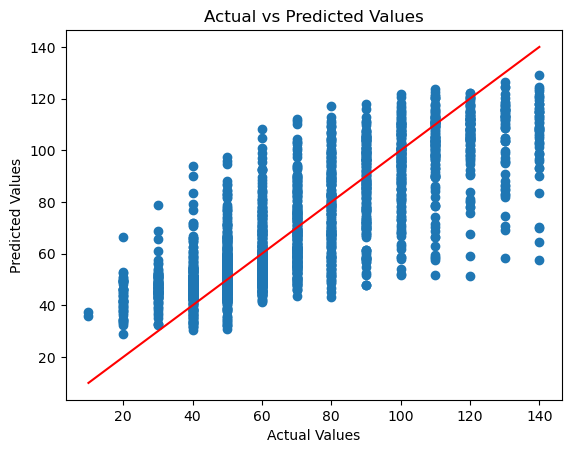

C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3819335297.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)


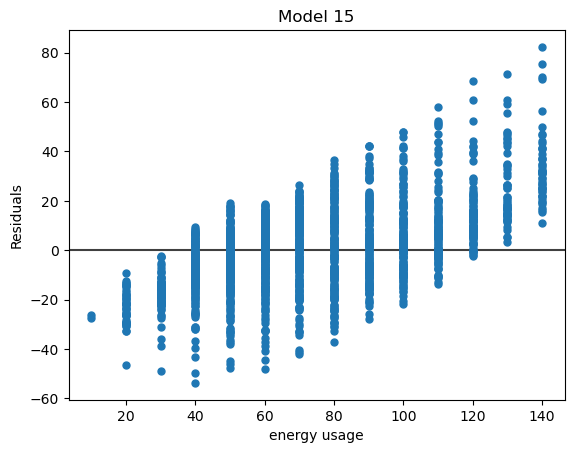

In [81]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model15 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model15.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history16 = model15.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

# r2 score
# Generate predictions
y_val_pred = model15.predict(X_val_transformedandscaled)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model 15", y_val, y_val_pred)

In [109]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model16 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model16.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history17 = model16.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
24/24 - 2s - loss: 5171.8008 - mean_absolute_error: 66.8948 - root_mean_squared_error: 71.3289 - val_loss: 6458.0405 - val_mean_absolute_error: 74.1855 - val_root_mean_squared_error: 79.8436 - lr: 0.0015 - 2s/epoch - 75ms/step
Epoch 2/100
24/24 - 0s - loss: 4782.5825 - mean_absolute_error: 64.7611 - root_mean_squared_error: 68.5585 - val_loss: 4753.8516 - val_mean_absolute_error: 64.2374 - val_root_mean_squared_error: 68.3543 - lr: 0.0015 - 392ms/epoch - 16ms/step
Epoch 3/100
24/24 - 0s - loss: 4228.7012 - mean_absolute_error: 60.4901 - root_mean_squared_error: 64.4011 - val_loss: 4204.8379 - val_mean_absolute_error: 60.5934 - val_root_mean_squared_error: 64.2176 - lr: 0.0015 - 377ms/epoch - 16ms/step
Epoch 4/100
24/24 - 1s - loss: 3405.6055 - mean_absolute_error: 53.3408 - root_mean_squared_error: 57.6603 - val_loss: 3059.5637 - val_mean_absolute_error: 50.5775 - val_root_mean_squared_error: 54.5772 - lr: 0.0015 - 784ms/epoch - 33ms/step
Epoch 5/100
24/24 - 1s - loss: 2447

80/80 [==============================] - 1s 3ms/step
R2 score: 0.6716621135237638
RMSE: 15.579401559446616
MAE: 11.469392603297523


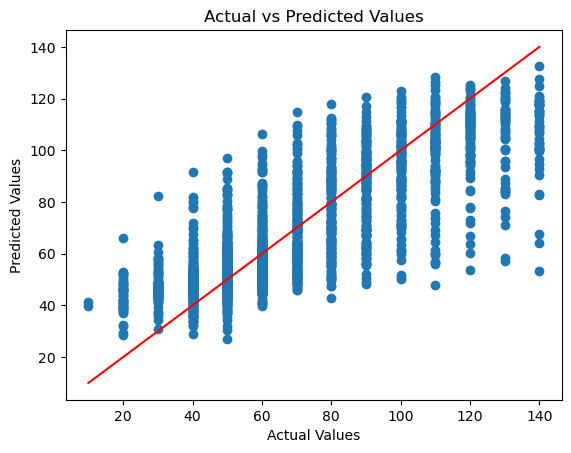

C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3819335297.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)


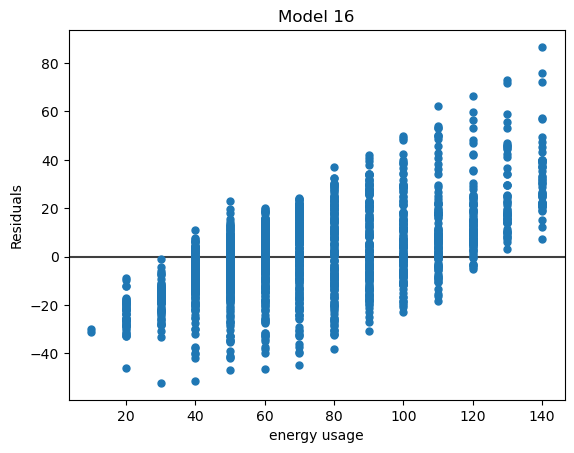

In [110]:
# r2 score
# Generate predictions
y_val_pred = model16.predict(X_val_transformedandscaled)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE: {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_val, y_val_pred)
print(f"MAE: {mae}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model 16", y_val, y_val_pred)

In [114]:
#create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_transformedandscaled)
X_val_poly = poly.transform(X_val_transformedandscaled)
X_test_poly = poly.transform(X_test_transformedandscaled)

#shape of the data
print("X_train shape: ", X_train_poly.shape)



X_train shape:  (11921, 465)


In [117]:
INPUT_DIM = X_train_poly.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model17 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model17.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history18 = model17.fit(
    X_train_poly,
    y_train,
    validation_data=(X_val_poly, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
24/24 - 2s - loss: 5220.2686 - mean_absolute_error: 66.9235 - root_mean_squared_error: 71.6717 - val_loss: 5091.1294 - val_mean_absolute_error: 65.8377 - val_root_mean_squared_error: 70.7709 - lr: 0.0015 - 2s/epoch - 88ms/step
Epoch 2/100
24/24 - 0s - loss: 4747.2583 - mean_absolute_error: 64.8037 - root_mean_squared_error: 68.3008 - val_loss: 5066.9702 - val_mean_absolute_error: 66.8866 - val_root_mean_squared_error: 70.6052 - lr: 0.0015 - 415ms/epoch - 17ms/step
Epoch 3/100
24/24 - 0s - loss: 4173.2593 - mean_absolute_error: 60.6645 - root_mean_squared_error: 63.9650 - val_loss: 4058.6379 - val_mean_absolute_error: 59.9686 - val_root_mean_squared_error: 63.0631 - lr: 0.0015 - 442ms/epoch - 18ms/step
Epoch 4/100
24/24 - 0s - loss: 3342.0085 - mean_absolute_error: 53.6312 - root_mean_squared_error: 57.0981 - val_loss: 3149.1616 - val_mean_absolute_error: 51.9120 - val_root_mean_squared_error: 55.3821 - lr: 0.0015 - 405ms/epoch - 17ms/step
Epoch 5/100
24/24 - 0s - loss: 2380

In [122]:
INPUT_DIM = X_train_poly.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.05
DROPOUT = 0.50
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=20)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.06, patience=15)

# create model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history19 = model.fit(
    X_train_poly,
    y_train,
    validation_data=(X_val_poly, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
24/24 - 2s - loss: 6883.1030 - mean_absolute_error: 66.9386 - root_mean_squared_error: 71.5892 - val_loss: 6688.6387 - val_mean_absolute_error: 68.1806 - val_root_mean_squared_error: 71.8069 - lr: 0.0015 - 2s/epoch - 99ms/step
Epoch 2/100
24/24 - 0s - loss: 6043.4512 - mean_absolute_error: 64.8714 - root_mean_squared_error: 68.2568 - val_loss: 6006.7310 - val_mean_absolute_error: 66.0872 - val_root_mean_squared_error: 69.0712 - lr: 0.0015 - 419ms/epoch - 17ms/step
Epoch 3/100
24/24 - 0s - loss: 5217.6797 - mean_absolute_error: 60.6474 - root_mean_squared_error: 63.7858 - val_loss: 5076.4800 - val_mean_absolute_error: 59.8724 - val_root_mean_squared_error: 63.3378 - lr: 0.0015 - 433ms/epoch - 18ms/step
Epoch 4/100
24/24 - 0s - loss: 4263.1294 - mean_absolute_error: 53.6006 - root_mean_squared_error: 56.9746 - val_loss: 4175.8481 - val_mean_absolute_error: 52.8339 - val_root_mean_squared_error: 56.6239 - lr: 0.0015 - 418ms/epoch - 17ms/step
Epoch 5/100
24/24 - 0s - loss: 3236

## ensemble learning

In [262]:
# copy of models - so I don't have to keep scrolling
# model 14
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.03
DROPOUT = 0.50
learningrate = 0.002
DELTA = 2.0
optimizer = Adam(learning_rate=learningrate)
# Calculate class weights
# sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model14 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="tanh",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="tanh",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="tahn",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model14.compile(
    optimizer=optimizer,
    loss=Huber(delta = DELTA),
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history15 = model14.fit(
    X_train_transformedandscaled,
    y_train,
    # sample_weight=sample_weights,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/100
24/24 - 4s - loss: 192.9578 - mean_absolute_error: 66.5224 - root_mean_squared_error: 71.8156 - val_loss: 166.4957 - val_mean_absolute_error: 65.5549 - val_root_mean_squared_error: 70.9662 - lr: 0.0020 - 4s/epoch - 182ms/step
Epoch 2/100
24/24 - 1s - loss: 149.8520 - mean_absolute_error: 62.2849 - root_mean_squared_error: 67.9612 - val_loss: 135.8243 - val_mean_absolute_error: 59.2979 - val_root_mean_squared_error: 65.2163 - lr: 0.0020 - 645ms/epoch - 27ms/step
Epoch 3/100
24/24 - 1s - loss: 121.8136 - mean_absolute_error: 53.6139 - root_mean_squared_error: 60.8318 - val_loss: 106.4796 - val_mean_absolute_error: 46.6339 - val_root_mean_squared_error: 53.4346 - lr: 0.0020 - 654ms/epoch - 27ms/step
Epoch 4/100
24/24 - 1s - loss: 90.7469 - mean_absolute_error: 39.5030 - root_mean_squared_error: 47.3630 - val_loss: 65.1897 - val_mean_absolute_error: 27.6216 - val_root_mean_squared_error: 36.7577 - lr: 0.0020 - 668ms/epoch - 28ms/step
Epoch 5/100
24/24 - 1s - loss: 57.4220 - mea

80/80 [==============================] - 1s 5ms/step


C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3819335297.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)


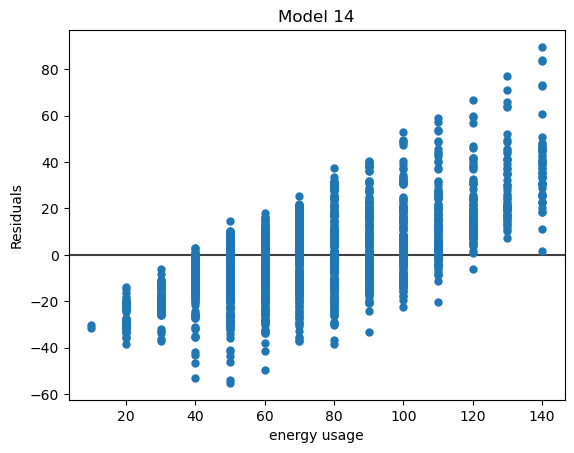

In [263]:
#plot residual plot
#get predictions
y_val_pred = model14.predict(X_val_transformedandscaled)
#flatten predictions
y_val_pred = y_val_pred.flatten()
plot_residuals("Model 14", y_val, y_val_pred)

In [264]:
#model 15
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.03
DROPOUT = 0.50
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.07, patience=15)

# create model
model15 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="tanh",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="tanh",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="tanh",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model15.compile(
    optimizer=optimizer,
    loss=Huber(delta=1.0),
    #metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history16 = model15.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/100
24/24 - 7s - loss: 134.2301 - val_loss: 112.1797 - lr: 0.0015 - 7s/epoch - 282ms/step
Epoch 2/100
24/24 - 1s - loss: 99.3517 - val_loss: 88.3241 - lr: 0.0015 - 1s/epoch - 49ms/step
Epoch 3/100
24/24 - 1s - loss: 80.1574 - val_loss: 72.4584 - lr: 0.0015 - 1s/epoch - 53ms/step
Epoch 4/100
24/24 - 1s - loss: 65.8599 - val_loss: 58.5763 - lr: 0.0015 - 1s/epoch - 50ms/step
Epoch 5/100
24/24 - 1s - loss: 50.8975 - val_loss: 41.7458 - lr: 0.0015 - 1s/epoch - 49ms/step
Epoch 6/100
24/24 - 2s - loss: 36.4027 - val_loss: 29.0421 - lr: 0.0015 - 2s/epoch - 75ms/step
Epoch 7/100
24/24 - 1s - loss: 28.1041 - val_loss: 25.4824 - lr: 0.0015 - 1s/epoch - 52ms/step
Epoch 8/100
24/24 - 1s - loss: 25.0919 - val_loss: 23.6807 - lr: 0.0015 - 1s/epoch - 48ms/step
Epoch 9/100
24/24 - 1s - loss: 23.7020 - val_loss: 22.7753 - lr: 0.0015 - 1s/epoch - 50ms/step
Epoch 10/100
24/24 - 2s - loss: 22.5164 - val_loss: 23.4280 - lr: 0.0015 - 2s/epoch - 74ms/step
Epoch 11/100
24/24 - 1s - loss: 21.5478 - val_

In [265]:
#model 16
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.03
DROPOUT = 0.50
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.07, patience=15)

# create model
model16 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model16.compile(
    optimizer=optimizer,
    loss=Huber(delta=1.0),
    #metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history17 = model16.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
24/24 - 4s - loss: 134.5367 - val_loss: 112.7085 - lr: 0.0015 - 4s/epoch - 160ms/step
Epoch 2/100
24/24 - 1s - loss: 99.5808 - val_loss: 88.1047 - lr: 0.0015 - 619ms/epoch - 26ms/step
Epoch 3/100
24/24 - 1s - loss: 80.3164 - val_loss: 72.2123 - lr: 0.0015 - 836ms/epoch - 35ms/step
Epoch 4/100
24/24 - 1s - loss: 65.9320 - val_loss: 56.5844 - lr: 0.0015 - 564ms/epoch - 24ms/step
Epoch 5/100
24/24 - 1s - loss: 52.1608 - val_loss: 44.2001 - lr: 0.0015 - 570ms/epoch - 24ms/step
Epoch 6/100
24/24 - 1s - loss: 37.5058 - val_loss: 31.5944 - lr: 0.0015 - 833ms/epoch - 35ms/step
Epoch 7/100
24/24 - 1s - loss: 28.6751 - val_loss: 25.9216 - lr: 0.0015 - 575ms/epoch - 24ms/step
Epoch 8/100
24/24 - 1s - loss: 25.5972 - val_loss: 24.0104 - lr: 0.0015 - 533ms/epoch - 22ms/step
Epoch 9/100
24/24 - 1s - loss: 24.1564 - val_loss: 23.4966 - lr: 0.0015 - 562ms/epoch - 23ms/step
Epoch 10/100
24/24 - 1s - loss: 23.0349 - val_loss: 22.6789 - lr: 0.0015 - 570ms/epoch - 24ms/step
Epoch 11/100
24/24 

In [266]:
# model 20 - linear regression

model20 = LinearRegression()
model20.fit(X_train_transformedandscaled, y_train)
# r2 score
r2 = model20.score(X_val_transformedandscaled, y_val)
print(f"R2 score: {r2}")


R2 score: 0.3670517740802045


In [267]:
# model 21 - decision tree regressor
model21 = DecisionTreeRegressor(max_depth=7, min_samples_split=2, min_samples_leaf=1)
model21.fit(X_train_transformedandscaled, y_train)
# r2 score
r2 = model21.score(X_val_transformedandscaled, y_val)
print(f"R2 score: {r2}")



# # Define the parameter grid
# param_grid = {
#     "max_depth": [5, 10, 15, 20, 25, 30],
#     "min_samples_split": [2, 5, 10, 15],
#     "min_samples_leaf": [1, 2, 5, 10],
# }

# # Create a DecisionTreeRegressor
# tree = DecisionTreeRegressor()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(tree, param_grid, cv=5, scoring="neg_mean_squared_error")

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train_transformedandscaled, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_

# #create the model with the best parameters
# model21 = DecisionTreeRegressor(**best_params)

# # Fit the model
# model21.fit(X_train_transformedandscaled, y_train)

# #r2 score
# r2 = model21.score(X_val_transformedandscaled, y_val)

R2 score: 0.4978957419172928


80/80 [==============================] - 0s 5ms/step
Epoch 1/100
24/24 - 3s - loss: 58.3027 - mean_absolute_error: 38.3716 - root_mean_squared_error: 47.4554 - val_loss: 39.2832 - val_mean_absolute_error: 26.9593 - val_root_mean_squared_error: 36.4196 - 3s/epoch - 119ms/step
Epoch 2/100
24/24 - 0s - loss: 30.3979 - mean_absolute_error: 22.8161 - root_mean_squared_error: 31.7554 - val_loss: 24.9990 - val_mean_absolute_error: 21.2840 - val_root_mean_squared_error: 29.4708 - 405ms/epoch - 17ms/step
Epoch 3/100
24/24 - 0s - loss: 23.0771 - mean_absolute_error: 20.7347 - root_mean_squared_error: 28.1077 - val_loss: 21.5976 - val_mean_absolute_error: 20.3677 - val_root_mean_squared_error: 27.9474 - 392ms/epoch - 16ms/step
Epoch 4/100
24/24 - 0s - loss: 21.1214 - mean_absolute_error: 20.3457 - root_mean_squared_error: 27.5022 - val_loss: 20.6095 - val_mean_absolute_error: 20.1463 - val_root_mean_squared_error: 27.5481 - 396ms/epoch - 17ms/step
Epoch 5/100
24/24 - 0s - loss: 20.5024 - mean_abs

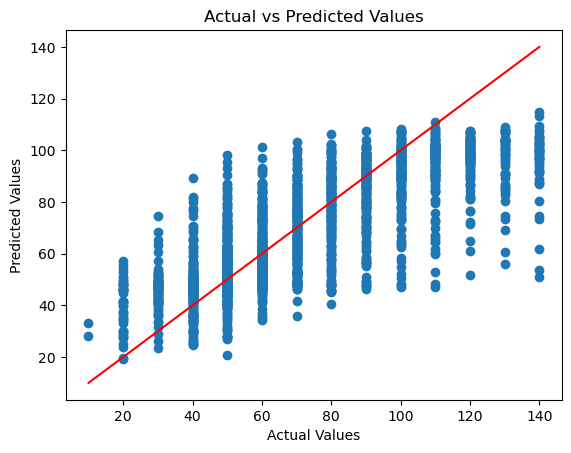

C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3819335297.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)


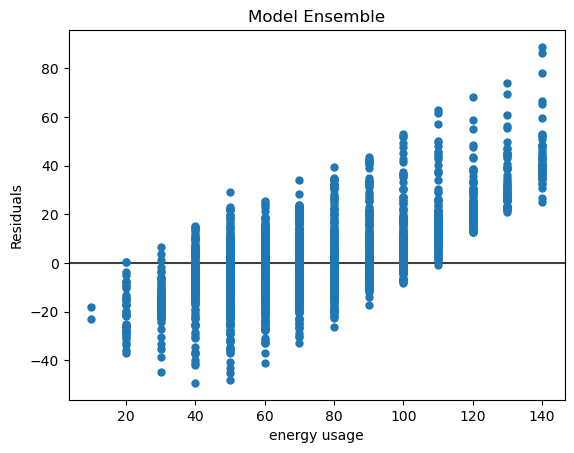

In [281]:
from scipy.stats import boxcox

# list of models
models = [model16, model15, model14]


# stacking models
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
learningrate = 0.0016
optimizer = Adam(learning_rate=learningrate)

# create meta features
# create meta features
meta_features = np.column_stack(
    [
            model.predict(X_train_transformedandscaled).reshape(-1, 1)
        for model in models
    ]
)

# create meta features for validation data
meta_val_features = np.column_stack(
    [
        model.predict(X_val_transformedandscaled).reshape(-1, 1)
        for model in models
    ]
)
# bocox transform
meta_features = boxcox(meta_features + 1, 0)
meta_val_features = boxcox(meta_val_features + 1, 0)


# scale
# scaler = StandardScaler().fit(meta_features)
# meta_features = scaler.transform(meta_features)
# meta_val_features = scaler.transform(meta_val_features)
# create meta model
# create model
meta_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(len(models))),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="tanh",
            kernel_regularizer=regularizers.l2(0.05),  # L2 regularization
        ),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="tanh",
            kernel_regularizer=regularizers.l2(0.05),  # L2 regularization
        ),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)
# Compile the meta-model
meta_model.compile(loss= Huber(), optimizer=optimizer   ,metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()])

# train the model
history_meta = meta_model.fit(
    meta_features,
    y_train,
    validation_data=(meta_val_features, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
)

# # Create meta-features for test data
# meta_val_features = np.column_stack(
#     [
#             model.predict(X_val_transformedandscaled).reshape(-1, 1)

#         for model in models
#     ]
# )


# Make final predictions
final_predictions = meta_model.predict(meta_val_features)

# Calculate and print scores
r2 = r2_score(y_val, final_predictions)
rmse = np.sqrt(mean_squared_error(y_val, final_predictions))
mae = mean_absolute_error(y_val, final_predictions)
print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Create scatter and residual plots
plt.scatter(y_val, final_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# flatten predictions
final_predictions_flat = final_predictions.flatten()
# Plot residuals
plot_residuals("Model Ensemble", y_val, final_predictions_flat)

80/80 [==============================] - 1s 6ms/step
R2 score: 0.6141649066608006
RMSE: 16.888502220148222
MAE: 12.263746329529644


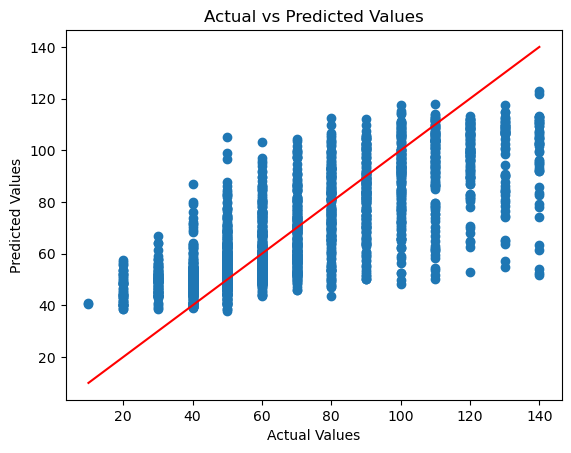

C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3819335297.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)


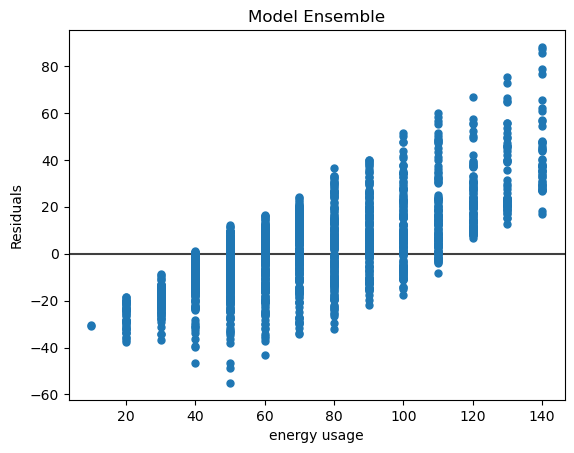

In [282]:
# get average predictions
# Predict with each model
predictions = [model.predict(X_val_transformedandscaled) for model in models]

# Convert list of predictions into an array
predictions = np.array(predictions)

# Calculate the average predictions
average_predictions = np.mean(predictions, axis=0)


# Calculate and print scores
r2 = r2_score(y_val, average_predictions)
rmse = np.sqrt(mean_squared_error(y_val, average_predictions))
mae = mean_absolute_error(y_val, average_predictions)
print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Create scatter and residual plots
plt.scatter(y_val, average_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model Ensemble", y_val, average_predictions.flatten())

R2 score: 0.6306089910671226
RMSE: 16.5246942429581
MAE: 12.120962727477439


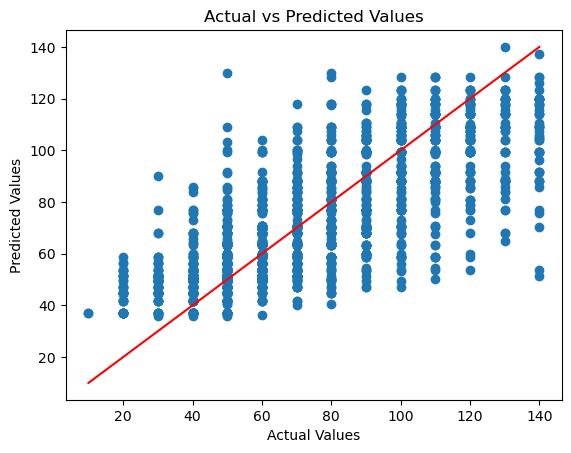

C:\Users\Joseph\AppData\Local\Temp\ipykernel_20876\3819335297.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_y, val_y - y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)


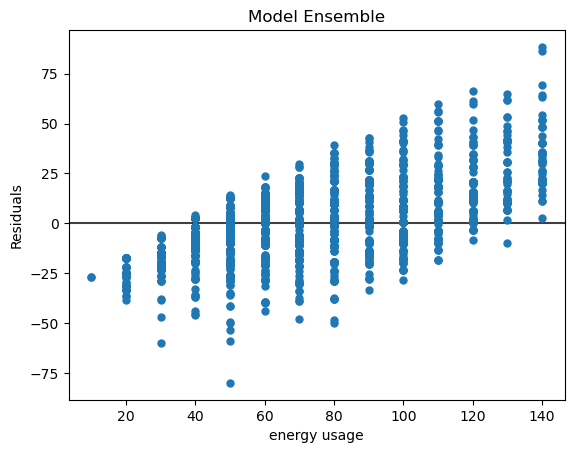

In [280]:
# decision tree meta model
meta_model_DTR = DecisionTreeRegressor(max_depth=7, min_samples_split=2, min_samples_leaf=1)
meta_model_DTR.fit(meta_features, y_train)
# Get predictions
final_predictions = meta_model_DTR.predict(meta_val_features)


# Calculate and print scores
r2 = r2_score(y_val, final_predictions)
rmse = np.sqrt(mean_squared_error(y_val, final_predictions))
mae = mean_absolute_error(y_val, final_predictions)
print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Create scatter and residual plots
plt.scatter(y_val, final_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# flatten predictions
final_predictions_flat = final_predictions.flatten()
# Plot residuals
plot_residuals("Model Ensemble", y_val, final_predictions_flat)